# Logistic Regression for Domain Relevance Classification

`Melina Paxinou`

MA Linguistics, Text Mining - Vrije Universiteit Amsterdam

June 27, 2025

## Imports

In [2]:
import pandas as pd
import spacy
import networkx as nx
from collections import defaultdict
nlp = spacy.load("en_core_web_md")
from spacy.tokens import Doc
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import ast

In [14]:
test_df_sentence = pd.read_csv('test_sentences.tsv', sep='\t', header=0)
train_df_sentence = pd.read_csv('train_sentences.tsv', sep='\t', header=0)
dev_df_sentence = pd.read_csv('dev_sentences.tsv', sep='\t', header=0)
anno_df_sentence = pd.read_csv('anno_sentences.tsv', sep='\t', header=0)

## Features

In [16]:
def build_dependency_graph(processed_doc):
    """
    Constructs a dependency graph from a processed sentence.

    Takes a processed spaCy doc object and creates a graph where each token 
    is represented as a node, and edges show syntactic dependencies between tokens. The graph 
    allows bidirectional traversal and each dependency relation is stored in both directions.

    Parameters:
        processed_doc: A spaCy-processed sentence containing dependency annotations.

    Returns:
        tuple: 
            - nx.Graph: undirected graph where nodes are token text (lowercased) 
              and edges represent dependency relations.
            - dict: mapping of (token 1, token 2) → direction ("↑" for child → parent, 
              "↓" for parent → child).
            - dict: mapping of (token 1, token 2) → dependency label.
    """
    edges = []
    dep_directions = {}
    dep_labels = {}

    for token in processed_doc:
        for child in token.children:
            edges.append((child.text.lower(), token.text.lower()))  # child → parent
            edges.append((token.text.lower(), child.text.lower()))  # parent → child
            dep_directions[(child.text.lower(), token.text.lower())] = "↑"
            dep_directions[(token.text.lower(), child.text.lower())] = "↓"
            dep_labels[(child.text.lower(), token.text.lower())] = child.dep_
            dep_labels[(token.text.lower(), child.text.lower())] = child.dep_

    return nx.Graph(edges), dep_directions, dep_labels


In [18]:
def find_dep_path(graph, dep_directions, dep_labels, word, predicate):
    """
    Finds the shortest dependency path between a given word and a predicate 
    in a dependency graph (with directions).

    Parameters:
        graph (nx.Graph): dependency graph where nodes are words (lowercased).
        dep_directions (dict): dict mapping (word 1, word 2) → direction 
                               ("↑" for child → parent, "↓" for parent → child).
        dep_labels (dict): dict mapping (word 1, word 2) → dependency label.
        word (str): starting word in the dependency tree.
        predicate (str): predicate word in the dependency tree.

    Returns:
        str: string representing the shortest dependency path 
             with dependency labels and direction arrows (e.g., "nsubj ↑ prep ↓").
             Returns "No Path" if no path exists between the given words.
    """
    try: # shortest dependency path between the given word and predicate
        dep_path = nx.shortest_path(graph, source=word.lower(), target=predicate.lower())
        # dependency labels and directional arrows
        arrow_path = [
            f"{dep_labels.get((dep_path[i], dep_path[i+1]), '?')} {dep_directions.get((dep_path[i], dep_path[i+1]), '?')}"
            for i in range(len(dep_path) - 1)
        ] 
        return " ".join(arrow_path)
    except (nx.NetworkXNoPath, ValueError, nx.NodeNotFound):
        return "No Path"


In [20]:
def extract_paths_to_domain_lemmas(sentence, domain_lemmas):
    """
    Extracts the shortest dependency path from each word in the sentence
    to the nearest domain-specific term, matched by lemma.

    Parameters:
        sentence (str): raw sentence string
        domain_lemmas (set): domain-specific terms as lemmas (lowercased)

    Returns:
        dict: word → shortest dependency path to any domain term (or "No Path")
    """
    doc = nlp(sentence)
    graph, dep_directions, dep_labels = build_dependency_graph(doc)

    # maps lemmas to token.text.lower()
    lemma_to_token = defaultdict(set)
    for token in doc:
        lemma_to_token[token.lemma_.lower()].add(token.text.lower())

    # gets all matching token texts for the domain lemmas
    matching_tokens = set()
    for lemma in domain_lemmas:
        matching_tokens.update(lemma_to_token.get(lemma.lower(), []))

    paths = {}
    for token in doc:
        token_text = token.text.lower()
        shortest_path = None
        shortest_path_str = None
        
        for domain_token in matching_tokens:
            if domain_token in graph:
                path_str = find_dep_path(graph, dep_directions, dep_labels, token_text, domain_token)
                if path_str != "No Path":
                    path_len = len(path_str.split())
                    if shortest_path is None or path_len < shortest_path:
                        shortest_path = path_len
                        shortest_path_str = path_str
        
        paths[token.text] = shortest_path_str if shortest_path_str else "No Path"
    
    return paths


In [22]:
def extract_features_from_sentence_level_df(df_sentence_level, domain_lemmas):
    import math
    from spacy.tokens import Doc
    df_sentence_level['sentence_tokens'] = df_sentence_level['sentence_tokens'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    # print(df_sentence_level.head())
    # print(df_sentence_level.iloc[0]['sentence_tokens'])
    # print(type(df_sentence_level.iloc[0]['sentence_tokens']))

    features = []
    domain_lemmas = [str(lemma).lower() for lemma in domain_lemmas]

    for _, row in df_sentence_level.iterrows():
        tokens = row['sentence_tokens']
        target_idx = row['target_token_index']

        cleaned_tokens = []
        for t in tokens:
            if t is None or (isinstance(t, float) and math.isnan(t)):
                cleaned_tokens.append("[empty]")
            else:
                cleaned_tokens.append(str(t))

        # builds spaCy Doc and process
        spacy_doc = Doc(nlp.vocab, words=cleaned_tokens)
        processed_doc = nlp(spacy_doc)

        # builds dependency graph, directions, labels 
        graph, dep_directions, dep_labels = build_dependency_graph(processed_doc)

        # finds all domain lemma indices in sentence
        domain_indices = [
            i for i, token in enumerate(processed_doc)
            if token.lemma_.lower() in domain_lemmas
        ]

        path_feature = "No Path"
        immunotherapy_token = "no relevant tokens"

        if domain_indices:
            shortest_path_str = None
            chosen_domain_lemma = None

            for domain_idx in domain_indices:
                try:
                    path_str = find_dep_path(
                        graph,
                        dep_directions,
                        dep_labels,
                        processed_doc[target_idx].text.lower(),
                        processed_doc[domain_idx].text.lower()
                    )
                except Exception:
                    path_str = "No Path"

                if path_str != "No Path":
                    if shortest_path_str is None or len(path_str) < len(shortest_path_str):
                        shortest_path_str = path_str
                        chosen_domain_lemma = processed_doc[domain_idx].lemma_

            if shortest_path_str is not None:
                path_feature = shortest_path_str
                immunotherapy_token = chosen_domain_lemma

        features.append({
            'target_token': cleaned_tokens[target_idx],
            'path_to_immuno': path_feature,
            'immunotherapy_token': immunotherapy_token
        })

    return features


In [24]:
immunotherapy_terms = [
    "immunotherapy", "immune", "antigen", "antibody", "vaccine", "checkpoint", "pd-1",
    "pd-l1", "ctla-4", "cytokine", "t-cell", "b-cell", "lymphocyte", "macrophage",
    "dendritic", "interleukin", "tumor", "cancer", "melanoma", "car-t", "monoclonal",
    "adoptive", "therapy", "immunomodulation", "immunosuppression", "immunogenic",
    "immune-related", "tolerance", "antigen-presenting", "fusion-protein", "biomarker",
    "neoplasm", "oncology", "immune-checkpoint", "effector", "regulatory", "inflammation",
    "autoimmune", "perforin", "immune-response", "tumour", "immune-activation",
    "allergy", "adenocarcinoma", "adenovirus", "biopsy", "bone marrow", "checkpoint inhibitor",
    "chemotherapy", "clinical trial", "endocrine", "genetic mutation", "immune modulator",
    "immune system", "immunohistochemistry", "immuno-oncology", "insulin", "insulinoma",
    "lymph", "lymph node", "melanocytes", "radiation", "recurrence", "remission",
    "stem cell", "white blood cell"
]


In [26]:
train_features = extract_features_from_sentence_level_df(train_df_sentence, immunotherapy_terms)

In [27]:
dev_features = extract_features_from_sentence_level_df(dev_df_sentence, immunotherapy_terms)

In [28]:
test_features = extract_features_from_sentence_level_df(test_df_sentence, immunotherapy_terms)

In [29]:
test_features[:20]

[{'target_token': 'barrier',
  'path_to_immuno': 'pobj ↑ prep ↑ nsubj ↓ amod ↓',
  'immunotherapy_token': 'immune'},
 {'target_token': 'bridge',
  'path_to_immuno': 'pobj ↑ prep ↑ pcomp ↑ prep ↑ nsubj ↓',
  'immunotherapy_token': 'therapy'},
 {'target_token': 'landmark',
  'path_to_immuno': 'prep ↓ prep ↑',
  'immunotherapy_token': 'cancer'},
 {'target_token': 'pillar',
  'path_to_immuno': 'prep ↓ prep ↑ dobj ↑ nsubj ↓ compound ↓',
  'immunotherapy_token': 'checkpoint'},
 {'target_token': 'pillar',
  'path_to_immuno': 'prep ↓ pcomp ↓ dobj ↓',
  'immunotherapy_token': 'tumour'},
 {'target_token': 'platform',
  'path_to_immuno': 'pobj ↑ prep ↑',
  'immunotherapy_token': 'immunotherapy'},
 {'target_token': 'salvage',
  'path_to_immuno': 'compound ↑ prep ↓ pobj ↓ prep ↓ pobj ↓',
  'immunotherapy_token': 'cancer'},
 {'target_token': 'regulatory',
  'path_to_immuno': '',
  'immunotherapy_token': 'regulatory'},
 {'target_token': 'regulatory',
  'path_to_immuno': '',
  'immunotherapy_token': '

In [30]:
anno_features = extract_features_from_sentence_level_df(anno_df_sentence, immunotherapy_terms)

In [31]:
def extract_gold_labels(df):
    
    return df['is_it_relevant'].tolist()


In [32]:
train_gold = extract_gold_labels(train_df_sentence)

In [33]:
dev_gold = extract_gold_labels(dev_df_sentence)

In [34]:
test_gold = extract_gold_labels(test_df_sentence)

In [35]:
train_gold[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
anno_gold = extract_gold_labels(anno_df_sentence)

## Logistic Regression

In [37]:
def create_classifier(train_feats, train_targets):
    """
    Creates and trains a classifier using Logistic Regression.

    Parameters:
    train_feats (list): List of feature dictionaries for training data.
    train_targets (list): List of target labels for training data.

    Returns:
    model: Trained logistic regression model.
    vec: Fitted DictVectorizer for feature transformation.
    encoder: Fitted LabelEncoder for target encoding.
    """
    
    # converts the feature dictionaries into a sparse matrix with DictVectorizer
    vec = DictVectorizer()  
    features_vectorized = vec.fit_transform(train_feats) 
    
    # initializes Logistic Regression model and trains
    logreg = LogisticRegression(max_iter=2000, solver='saga')  
    model = logreg.fit(features_vectorized, train_targets)  

    return model, vec

In [38]:
logreg_model, logreg_vec = create_classifier(train_features, train_gold)

In [40]:
def classify_data(model, vec, feats):
    """
    Transforms input features using a vectorizer and predicts labels using a trained model.

    Parameters:
        model: trained logreg model.
        vec: vectorizer.
        feats: features to be transformed and classified.

    Returns:
        predicted labels for the input features.
    """
    feats = vec.transform(feats)
    predictions = model.predict(feats)
    return predictions

In [41]:
pred = classify_data(logreg_model, logreg_vec, anno_features)

In [42]:
pred[:20]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
test_pred = classify_data(logreg_model, logreg_vec, test_features)

In [45]:
def write_predictions_to_tsv(input_file, output_file, predictions, gold_labels):
    """
    Writes predictions and gold labels to a TSV file, appending them to each token line.
    Skips the header line (first line) and aligns predictions/gold labels with tokens.

    Parameters:
    input_file : str
        Path to the original token-level input file (with header).
    output_file : str
        Path to the output TSV file with predictions and gold labels.
    predictions : list of int
        Predicted labels (e.g., 0 or 1).
    gold_labels : list of int
        True labels (e.g., 0 or 1).
    """
    if isinstance(predictions[0], list):
        predictions = [p for sublist in predictions for p in sublist]
    if isinstance(gold_labels[0], list):
        gold_labels = [g for sublist in gold_labels for g in sublist]

    with open(input_file, "r", encoding="utf-8") as fin, \
         open(output_file, "w", encoding="utf-8") as fout:

        idx = 0
        for line_num, line in enumerate(fin):
            stripped = line.strip()

            if line_num == 0:
                fout.write(line.rstrip("\n") + "\tpred\n")
                continue

            if stripped == "" or stripped.startswith("#"):
                fout.write(line)
                continue

            columns = stripped.split()
            token_text = columns[0] if len(columns) > 0 else ""

            if token_text == "":
                fout.write(line.rstrip("\n") + "\t_\t_\n")
                continue

            try:
                pred_label = predictions[idx]
                gold_label = gold_labels[idx]
            except IndexError:
                raise IndexError(
                    f"Prediction/gold label index {idx} out of range. "
                    f"Check if predictions/gold labels match input tokens."
                )

            fout.write(line.rstrip("\n") + f"\t{pred_label}\n")
            idx += 1


In [46]:
write_predictions_to_tsv('anno_sentences.tsv', 'anno_baseline_predictions.tsv', pred, anno_gold)

In [47]:
write_predictions_to_tsv('test_sentences.tsv', 'test_baseline_predictions.tsv', test_pred, test_gold)

## Evaluation

In [48]:
def evaluate_file(tsv_file):
    """
    Evaluate a TSV file with gold and predicted labels by creating a classification report and confusion matrix.
    Evaluation is restricted to rows where is_metaphor == 1 (i.e., target metaphor tokens).

    Parameters:
        tsv_file (str): Path to the TSV file.

    Returns:
        None
    """

    df = pd.read_csv(tsv_file, sep="\t")

    y_true = df["is_it_relevant"].apply(lambda x: 1 if x == 1 else 0).tolist()
    y_pred = df["pred"].apply(lambda x: 1 if x == 1 else 0).tolist()

    print("Classification Report:")
    print(classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=['IRRELEVANT (0)', 'RELEVANT (1)'],
        digits=3,
        zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['IRRELEVANT (0)', 'RELEVANT (1)'])

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap="magma_r", ax=ax)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

Classification Report:
                precision    recall  f1-score   support

IRRELEVANT (0)      0.933     0.389     0.549        36
  RELEVANT (1)      0.371     0.929     0.531        14

      accuracy                          0.540        50
     macro avg      0.652     0.659     0.540        50
  weighted avg      0.776     0.540     0.544        50



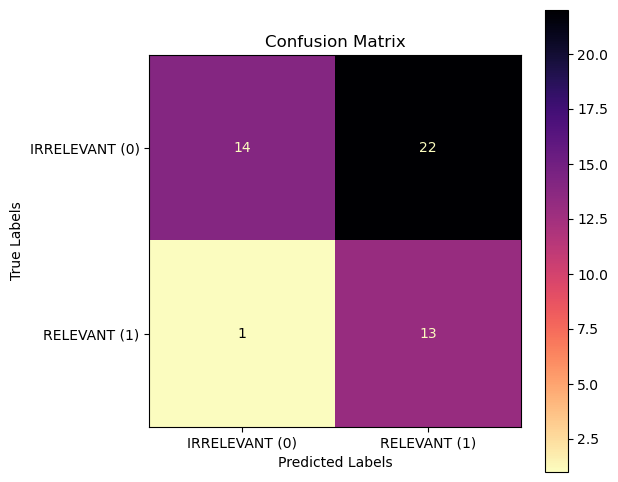

In [49]:
evaluate_file('anno_baseline_predictions.tsv')

Classification Report:
                precision    recall  f1-score   support

IRRELEVANT (0)      0.863     0.873     0.868       181
  RELEVANT (1)      0.791     0.777     0.784       112

      accuracy                          0.836       293
     macro avg      0.827     0.825     0.826       293
  weighted avg      0.836     0.836     0.836       293



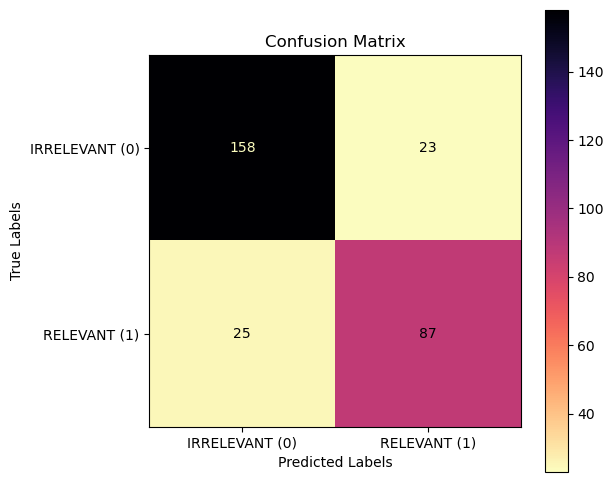

In [50]:
evaluate_file('test_baseline_predictions.tsv')

In [53]:
def show_misclassified_tokens(tsv_file):
    columns = [
        # "text_id",
        "sentence_number",
        "sentence_tokens",
        "token_text",
        "metaphor",
        "is_it_relevant",
        "text_id",
        "pred"
    ]

    df = pd.read_csv(tsv_file, sep="\t", header=0, names=columns)

    df["is_it_relevant"] = df["is_it_relevant"].apply(lambda x: 1 if x == 1 else 0)
    df["pred"] = df["pred"].apply(lambda x: 1 if x == 1 else 0)

    errors_df = df[df["is_it_relevant"] != df["pred"]]

    errors_df = errors_df[["sentence_number",
        "sentence_tokens",
        "token_text",
        "metaphor",
        "is_it_relevant",
        "pred"]]

    print(f"Number of misclassified metaphor tokens: {len(errors_df)}")
    display(errors_df)  

    return errors_df


In [ ]:
errors = show_misclassified_tokens("anno_baseline_predictions.tsv")

In [ ]:
test_errors = show_misclassified_tokens("test_baseline_predictions.tsv")

In [77]:

def show_misclassified_tokens(tsv_file):
    columns = [
        "sentence_number",
        "sentence_tokens",
        "token_text",  
        "metaphor",
        "is_it_relevant",
        "text_id",
        "pred"
    ]

    df = pd.read_csv(tsv_file, sep="\t", header=0, names=columns)

    df["is_it_relevant"] = df["is_it_relevant"].apply(lambda x: 1 if x == 1 else 0)
    df["pred"] = df["pred"].apply(lambda x: 1 if x == 1 else 0)

    df["token_text"] = df["token_text"].astype(int)

    df["tokens_list"] = df["sentence_tokens"].apply(lambda s: s.split())

    misclassified = df[df["is_it_relevant"] != df["pred"]].copy()

    misclassified["token_str"] = misclassified.apply(
        lambda row: row["tokens_list"][row["token_text"]]
        if row["token_text"] < len(row["tokens_list"])
        else "[INDEX_ERR]",
        axis=1
    )

    fp_rows = misclassified[
        (misclassified["is_it_relevant"] == 0) & (misclassified["pred"] == 1)
    ]
    fn_rows = misclassified[
        (misclassified["is_it_relevant"] == 1) & (misclassified["pred"] == 0)
    ]

    fp_tokens = fp_rows["token_str"].tolist()
    fn_tokens = fn_rows["token_str"].tolist()

    print(f"Number of misclassified metaphor tokens: {len(misclassified)}")
    print(f"\nFalse Positives ({len(fp_tokens)}):")
    for _, row in fp_rows.iterrows():
        print(f'[FP] Token: "{row["token_str"]}" | Sentence: {" ".join(row["tokens_list"])}\n')

    print(f"\nFalse Negatives ({len(fn_tokens)}):")
    for _, row in fn_rows.iterrows():
        print(f'[FN] Token: "{row["token_str"]}" | Sentence: {" ".join(row["tokens_list"])}\n')

    return fp_tokens, fn_tokens


In [ ]:
anno_fp, anno_fn = show_misclassified_tokens("anno_baseline_predictions.tsv")

In [ ]:
print(anno_fp, '\n', anno_fn)

In [ ]:
test_fp, test_fn = show_misclassified_tokens("test_baseline_predictions.tsv")

In [ ]:
print(test_fp)
print(test_fn)